# **Machine Learning using Grammatical Evolution**
### Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Clone GRAPE repository***

In [1]:
import os.path

In [2]:
PATH = '/users/ranyahwigi/desktop/FYP/grape'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /users/ranyahwigi/desktop/FYP/grape/

grape directory already exists
/Users/ranyahwigi/Desktop/FYP/grape


In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [4]:
!pip install deap
!pip install numpy
!pip install -U imbalanced-learn

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math

### ***Preparing Data***

**Smaller dataset**

In [5]:
# loading in the dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

**Extracting information on the data**

*Size of dataset*

In [6]:
# number of rows in dataset
number_of_samples = data['PatientID'].count()

**Dropping columns from dataset**

In [7]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [8]:
final_number_of_columns = len(data.columns)

**Train and test split**

In [9]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

Training (X,Y):	 (33625, 104) (33625,)
Test (X,Y):	 (14411, 104) (14411,)


**Check grammar file**

In [19]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|

**Setup grammar**

In [20]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar.bnf")

### ***Fitness Function***

In [10]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
    numerator = (TP+TN)
    denominator = (TP+TN+FP+FN)
    fitness = numerator / denominator

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [22]:
POPULATION_SIZE = 200
MAX_GENERATIONS = 100
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 17
MIN_INIT_TREE_DEPTH = 7
MAX_TREE_DEPTH = 27
MAX_WRAPS = 0
CODON_SIZE = 320

**Creating DEAP toolbox**

In [23]:
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

toolbox.register("select", ge.selTournament, tournsize=5)

toolbox.register("mate", ge.crossover_onepoint)

toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [24]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std      	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.501639	0.0275864	0.419539	0.573978	0.408091    	315            	417.105   	1891      	0             	6.67614        
1  	127    	0.503167	0.0255507	0.419539	0.55884 	0.556866    	85             	454.225   	1783      	0.00211978    	4.10446        
2  	15     	0.50804 	0.0238636	0.419539	0.55884 	0.556866    	85             	213.42    	937       	0.00118518    	4.0806         
3  	10     	0.505944	0.0277016	0.419271	0.602706	0.604052    	898            	209.275   	975       	0.0011549     	4.12098        
4  	17     	0.514557	0.0290651	0.398067	0.616089	0.620012    	736            	197.59    	987       	0.0011692     	3.88382        
5  	13     	0.512582	0.0342233	0.398067	0.615822	0.620012    	736            	251.765   	953       	0.00113773    	3.87088        
6  	6      	0.516616	0.0378011	0.382989	0.629086	0.634793    	368            	227.9

62 	2      	0.550283	0.0683759	0.366781	0.634349	0.641524    	521            	926.985   	1591      	0.00148106    	4.03036        
63 	6      	0.545118	0.0693488	0.366781	0.634617	0.641524    	521            	933.695   	1587      	0.00115108    	4.0692         
64 	4      	0.537275	0.0666164	0.366781	0.634409	0.641524    	521            	993.1     	1593      	0.001158      	3.93399        
65 	7      	0.539256	0.069786 	0.366781	0.63429 	0.641524    	521            	986.88    	1651      	0.00115371    	3.81363        
66 	5      	0.548647	0.0655098	0.366781	0.63426 	0.641524    	521            	934.095   	1636      	0.00117135    	3.904          
67 	9      	0.547794	0.0705467	0.366781	0.634587	0.641524    	521            	931.68    	1679      	0.00114202    	3.67835        
68 	5      	0.545091	0.0772282	0.366781	0.634617	0.641524    	521            	902.915   	1820      	0.00117302    	3.9075         
69 	4      	0.548656	0.069885 	0.366781	0.640565	0.644785    	715            	908.7

**Statistics**

In [25]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.501639,0.027586,0.419539,0.573978,0.408091,315,417.105,1891,0.000000,6.676142
1,1,127,0.503167,0.025551,0.419539,0.558840,0.556866,85,454.225,1783,0.002120,4.104463
2,2,15,0.508040,0.023864,0.419539,0.558840,0.556866,85,213.420,937,0.001185,4.080602
3,3,10,0.505944,0.027702,0.419271,0.602706,0.604052,898,209.275,975,0.001155,4.120976
4,4,17,0.514557,0.029065,0.398067,0.616089,0.620012,736,197.590,987,0.001169,3.883816
5,5,13,0.512582,0.034223,0.398067,0.615822,0.620012,736,251.765,953,0.001138,3.870878
6,6,6,0.516616,0.037801,0.382989,0.629086,0.634793,368,227.930,987,0.001160,3.866182
7,7,3,0.518007,0.039639,0.382989,0.629086,0.634793,368,261.315,954,0.001154,4.009388
8,8,1,0.520734,0.044340,0.382989,0.627807,0.634793,368,255.550,956,0.001162,3.856341
9,9,2,0.517951,0.050823,0.369190,0.629115,0.634793,368,256.125,1024,0.001142,3.907058


**Best individual**

In [26]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
neg(add(sub(neg(sub(neg(x[60]),sub(63.06,x[70]))),sub(x[46],79.57)),sub(pdiv(22.78,sub(x[85],43.59)),50.13)))

Training Fitness:  0.6425873605947955

Depth:  9

Length of the genome:  715

Used portion of the genome: 0.06



Testing best individual

In [11]:
x = X_test

def get_confusion_matrix(Y_labels, Y_predictions):
    TP, FN, TN, FP = 0, 0, 0, 0
    for x, y in zip(Y_labels, Y_predictions):
      if x == 0:
        if y == 0:
          TN = TN + 1
        else:
          FP = FP + 1
      elif x == 1:
        if y == 1:
          TP = TP + 1
        else:
          FN = FN + 1
    return TP, FN, TN, FP

In [12]:
predictions = neg(add(sub(neg(sub(neg(x[60]),sub(63.06,x[70]))),sub(x[46],79.57)),sub(pdiv(22.78,sub(x[85],43.59)),50.13)))
print("Predictions ", predictions)
print()

Y_prediction_class = [1 if predictions[i] > 0 else 0 for i in range(len(predictions))]
print("Labels", Counter(Y_prediction_class))
print()

print("************ Fitness Metrics ************")
print()

TP, FN, TN, FP = get_confusion_matrix(Y_test, Y_prediction_class)
numerator = (TP+TN)
denominator = (TP+TN+FP+FN)
accuracy = numerator / denominator
print("Accuracy:             ", accuracy)
print()

TPR = TP/(TP+FN)
print("True positive rate:   ", TPR)
print()

TNR = TN/(TN+FP)
print("True negative rate:   ", TNR)
print()

FPR = FP/(FP+TN)
print("False positive rate:  ", FPR)
print()

FNR = FN/(FN+TP)
print("False negative rate:  ", FNR)
print()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, Y_prediction_class)
print("Area under the curve: ", auc)

Predictions  [-90.50403104  26.17928977   8.6519406  ...   8.63059877  41.16568982
 -14.87480413]

Labels Counter({1: 10027, 0: 4384})

************ Fitness Metrics ************

Accuracy:              0.6484629796683089

True positive rate:    0.8442748091603054

True negative rate:    0.45267832361920624

False positive rate:   0.5473216763807938

False negative rate:   0.15572519083969466

Area under the curve:  0.6484765663897558


**Best individuals plots**

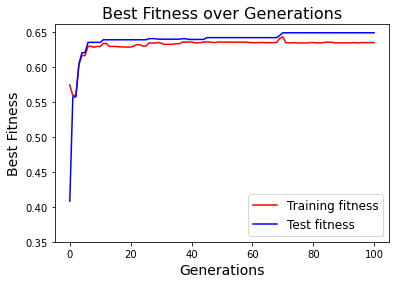

In [27]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.yticks(np.arange(0.35, 0.67, 0.05))
plt.show()

**Average fitness plot**

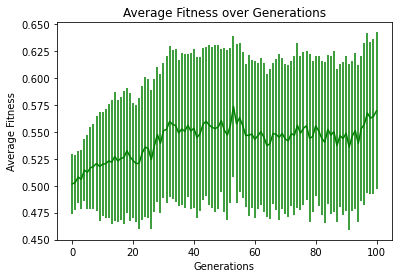

In [28]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

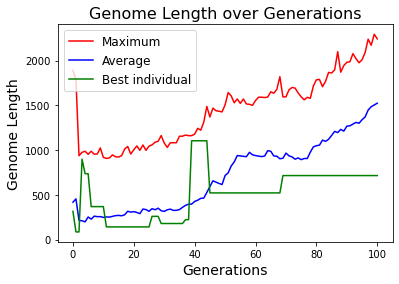

In [29]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()